<a href="https://colab.research.google.com/github/seheremir/Learning-Activation-Functions-in-Neural-Networks/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

BASE_DIR = "/content/drive/MyDrive/aktivasyon_fonk_tahmini"
RESULTS_DIR = os.path.join(BASE_DIR, "results")
MODELS_DIR = os.path.join(BASE_DIR, "models")
PLOTS_DIR = os.path.join(BASE_DIR, "plots")

for d in [BASE_DIR, RESULTS_DIR, MODELS_DIR, PLOTS_DIR]:
    os.makedirs(d, exist_ok=True)

print("📁 Klasör yapısı hazır.")


Mounted at /content/drive
📁 Klasör yapısı hazır.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim


In [ ]:
data = load_breast_cancer()
X = data.data
y = data.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
y_test  = torch.tensor(y_test, dtype=torch.float32).view(-1,1)


In [ ]:
class AdaptiveActivation(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = nn.Parameter(torch.randn(1))
        self.beta  = nn.Parameter(torch.randn(1))
        self.gamma = nn.Parameter(torch.randn(1))

    def forward(self, x):
        return (
            self.alpha * torch.relu(x) +
            self.beta  * torch.tanh(x) +
            self.gamma * torch.sigmoid(x)
        )


In [ ]:
class AdaptiveANN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, 64)
        self.act1 = AdaptiveActivation()

        self.fc2 = nn.Linear(64, 32)
        self.act2 = AdaptiveActivation()

        self.out = nn.Linear(32, 1)

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        return torch.sigmoid(self.out(x))


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AdaptiveANN(X_train.shape[1]).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 100
train_losses = []


In [ ]:
X_train_d = X_train.to(device)
y_train_d = y_train.to(device)

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_d)
    loss = criterion(outputs, y_train_d)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")


Epoch 0 | Loss: 0.7091
Epoch 10 | Loss: 0.5866
Epoch 20 | Loss: 0.4558
Epoch 30 | Loss: 0.2991
Epoch 40 | Loss: 0.1845
Epoch 50 | Loss: 0.1276
Epoch 60 | Loss: 0.0976
Epoch 70 | Loss: 0.0813
Epoch 80 | Loss: 0.0713
Epoch 90 | Loss: 0.0644


In [ ]:
model.eval()
with torch.no_grad():
    preds = model(X_test.to(device)).cpu().numpy()
    preds_bin = (preds > 0.5).astype(int)

y_true = y_test.numpy()

acc = accuracy_score(y_true, preds_bin)
f1  = f1_score(y_true, preds_bin)
auc = roc_auc_score(y_true, preds)

metrics = {
    "accuracy": acc,
    "f1_score": f1,
    "roc_auc": auc
}

print(metrics)

pd.DataFrame([metrics]).to_csv(
    os.path.join(RESULTS_DIR, "metrics.csv"),
    index=False
)


{'accuracy': 0.972027972027972, 'f1_score': 0.9775280898876404, 'roc_auc': np.float64(0.9960167714884697)}


In [ ]:
activation_params = {
    "layer1": {
        "alpha": model.act1.alpha.item(),
        "beta":  model.act1.beta.item(),
        "gamma": model.act1.gamma.item()
    },
    "layer2": {
        "alpha": model.act2.alpha.item(),
        "beta":  model.act2.beta.item(),
        "gamma": model.act2.gamma.item()
    }
}

pd.DataFrame(activation_params).to_csv(
    os.path.join(RESULTS_DIR, "learned_activations.csv")
)

activation_params


{'layer1': {'alpha': -0.2528246343135834,
  'beta': 1.0339637994766235,
  'gamma': 0.27494606375694275},
 'layer2': {'alpha': 1.5225701332092285,
  'beta': -0.43110913038253784,
  'gamma': 0.4746367335319519}}

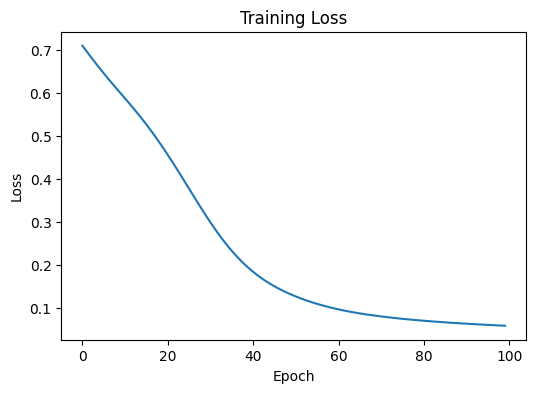

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.savefig(os.path.join(PLOTS_DIR, "loss_curve.png"))
plt.show()


In [ ]:
torch.save(
    model.state_dict(),
    os.path.join(MODELS_DIR, "adaptive_ann.pth")
)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, json, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = "/content/drive/MyDrive/aktivasyon_fonk_tahmini"
RUNS_DIR = os.path.join(BASE_DIR, "runs")
os.makedirs(RUNS_DIR, exist_ok=True)

def make_run_dir(tag="exp"):
    ts = time.strftime("%Y%m%d-%H%M%S")
    run_dir = os.path.join(RUNS_DIR, f"{ts}_{tag}")
    os.makedirs(run_dir, exist_ok=True)
    for sub in ["results", "models", "plots", "logs"]:
        os.makedirs(os.path.join(run_dir, sub), exist_ok=True)
    return run_dir

def set_seed(seed=42):
    import torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("✅ Hazır. run_dir oluşturmak için: run_dir = make_run_dir('gated_baselines')")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Hazır. run_dir oluşturmak için: run_dir = make_run_dir('gated_baselines')


In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch

set_seed(42)
run_dir = make_run_dir("gated_baselines")

data = load_breast_cancer()
X = data.data
y = data.target

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np  = scaler.transform(X_test_np)

X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test  = torch.tensor(X_test_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32).view(-1,1)
y_test  = torch.tensor(y_test_np, dtype=torch.float32).view(-1,1)

# scaler kaydet
import joblib
joblib.dump(scaler, os.path.join(run_dir, "models", "scaler.joblib"))

print("✅ Veri hazır:", X_train.shape, X_test.shape)
print("📁 run_dir:", run_dir)


✅ Veri hazır: torch.Size([426, 30]) torch.Size([143, 30])
📁 run_dir: /content/drive/MyDrive/aktivasyon_fonk_tahmini/runs/20251217-091415_gated_baselines


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdaptiveActivationGated(nn.Module):
    """
    w = softmax(logits / T)  -> w0+w1+w2 = 1, w_i in (0,1)
    f(x) = w0*ReLU(x) + w1*Tanh(x) + w2*Sigmoid(x)
    """
    def __init__(self, temperature=1.0):
        super().__init__()
        self.logits = nn.Parameter(torch.zeros(3))  # [relu, tanh, sigmoid]
        self.temperature = temperature

    def forward(self, x):
        w = F.softmax(self.logits / self.temperature, dim=0)
        return w[0]*F.relu(x) + w[1]*torch.tanh(x) + w[2]*torch.sigmoid(x)

    @torch.no_grad()
    def weights(self):
        w = F.softmax(self.logits / self.temperature, dim=0)
        return w.detach().cpu().numpy()


In [ ]:
class MLPBaseline(nn.Module):
    def __init__(self, input_dim, act_name="relu"):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)

        if act_name == "relu":
            self.act = nn.ReLU()
        elif act_name == "tanh":
            self.act = nn.Tanh()
        elif act_name == "sigmoid":
            self.act = nn.Sigmoid()
        else:
            raise ValueError("act_name must be one of: relu, tanh, sigmoid")

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        return torch.sigmoid(self.out(x))


class AdaptiveMLP(nn.Module):
    def __init__(self, input_dim, temperature=1.0):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.act1 = AdaptiveActivationGated(temperature=temperature)

        self.fc2 = nn.Linear(64, 32)
        self.act2 = AdaptiveActivationGated(temperature=temperature)

        self.out = nn.Linear(32, 1)

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        return torch.sigmoid(self.out(x))


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ device:", device)

def train_model(model, X_train, y_train, X_val, y_val, *,
                lr=1e-3, epochs=150, weight_decay=1e-4,
                patience=20, batch_size=64, run_dir=None, model_name="model"):
    import torch.optim as optim

    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # mini-batch
    ds = torch.utils.data.TensorDataset(X_train, y_train)
    dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

    history = {"train_loss": [], "val_loss": []}

    best_val = float("inf")
    best_state = None
    bad = 0

    for ep in range(epochs):
        model.train()
        tr_losses = []
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            tr_losses.append(loss.item())

        tr_loss = float(np.mean(tr_losses))

        model.eval()
        with torch.no_grad():
            out_val = model(X_val.to(device))
            val_loss = criterion(out_val, y_val.to(device)).item()

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(val_loss)

        # early stopping
        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1

        if (ep % 10 == 0) or (ep == epochs-1):
            print(f"[{model_name}] ep={ep:03d} train={tr_loss:.4f} val={val_loss:.4f} best={best_val:.4f} bad={bad}")

        if bad >= patience:
            print(f"⏹️ Early stop at ep={ep}, best_val={best_val:.4f}")
            break

    # best state load
    if best_state is not None:
        model.load_state_dict(best_state)

    # save model + history
    if run_dir:
        torch.save(model.state_dict(), os.path.join(run_dir, "models", f"{model_name}.pth"))
        pd.DataFrame(history).to_csv(os.path.join(run_dir, "logs", f"{model_name}_history.csv"), index=False)

        # loss plot
        plt.figure(figsize=(6,4))
        plt.plot(history["train_loss"], label="train")
        plt.plot(history["val_loss"], label="val")
        plt.xlabel("epoch"); plt.ylabel("loss"); plt.title(f"Loss: {model_name}")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(run_dir, "plots", f"{model_name}_loss.png"))
        plt.close()

    return model, history


@torch.no_grad()
def evaluate_model(model, X_test, y_test, run_dir=None, model_name="model"):
    model.eval()
    probs = model(X_test.to(device)).detach().cpu().numpy().reshape(-1)
    y_true = y_test.cpu().numpy().reshape(-1).astype(int)
    y_pred = (probs > 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, probs)

    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, probs)

    metrics = {"model": model_name, "accuracy": acc, "f1": f1, "roc_auc": auc}

    if run_dir:
        # metrics save
        pd.DataFrame([metrics]).to_csv(os.path.join(run_dir, "results", f"{model_name}_metrics.csv"), index=False)

        # confusion matrix plot
        plt.figure(figsize=(4.5,4))
        plt.imshow(cm)
        plt.title(f"Confusion Matrix: {model_name}")
        plt.xlabel("Pred"); plt.ylabel("True")
        plt.xticks([0,1]); plt.yticks([0,1])
        for i in range(2):
            for j in range(2):
                plt.text(j, i, cm[i,j], ha="center", va="center")
        plt.tight_layout()
        plt.savefig(os.path.join(run_dir, "plots", f"{model_name}_cm.png"))
        plt.close()

        # roc plot
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr)
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC: {model_name} (AUC={auc:.3f})")
        plt.tight_layout()
        plt.savefig(os.path.join(run_dir, "plots", f"{model_name}_roc.png"))
        plt.close()

    return metrics, cm


✅ device: cuda


In [ ]:
from sklearn.model_selection import train_test_split

# train içinden bir validation ayırıyoruz (early stopping için)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

configs = [
    ("baseline_relu",   lambda: MLPBaseline(X_train.shape[1], "relu")),
    ("baseline_tanh",   lambda: MLPBaseline(X_train.shape[1], "tanh")),
    ("baseline_sigmoid",lambda: MLPBaseline(X_train.shape[1], "sigmoid")),
    ("adaptive_gated_T1", lambda: AdaptiveMLP(X_train.shape[1], temperature=1.0)),
]

all_metrics = []
all_adaptive_weights = {}

for name, builder in configs:
    set_seed(42)
    model = builder()

    model, hist = train_model(
        model, X_tr, y_tr, X_val, y_val,
        lr=1e-3, epochs=200, weight_decay=1e-4,
        patience=25, batch_size=64,
        run_dir=run_dir, model_name=name
    )
    metrics, cm = evaluate_model(model, X_test, y_test, run_dir=run_dir, model_name=name)
    all_metrics.append(metrics)

    # Adaptive ise weights kaydet
    if "adaptive_gated" in name:
        w1 = model.act1.weights()
        w2 = model.act2.weights()
        all_adaptive_weights[name] = {
            "layer1_relu": float(w1[0]), "layer1_tanh": float(w1[1]), "layer1_sigmoid": float(w1[2]),
            "layer2_relu": float(w2[0]), "layer2_tanh": float(w2[1]), "layer2_sigmoid": float(w2[2]),
        }

# summary
df = pd.DataFrame(all_metrics).sort_values("roc_auc", ascending=False)
df_path = os.path.join(run_dir, "results", "summary_metrics.csv")
df.to_csv(df_path, index=False)
print("✅ Summary saved:", df_path)
df


[baseline_relu] ep=000 train=0.6821 val=0.6593 best=0.6593 bad=0
[baseline_relu] ep=010 train=0.1397 val=0.0918 best=0.0918 bad=0
[baseline_relu] ep=020 train=0.0687 val=0.0362 best=0.0362 bad=0
[baseline_relu] ep=030 train=0.0460 val=0.0207 best=0.0207 bad=0
[baseline_relu] ep=040 train=0.0382 val=0.0150 best=0.0150 bad=0
[baseline_relu] ep=050 train=0.0275 val=0.0132 best=0.0127 bad=2
[baseline_relu] ep=060 train=0.0280 val=0.0104 best=0.0104 bad=0
[baseline_relu] ep=070 train=0.0158 val=0.0109 best=0.0102 bad=4
[baseline_relu] ep=080 train=0.0121 val=0.0089 best=0.0087 bad=4
[baseline_relu] ep=090 train=0.0093 val=0.0080 best=0.0080 bad=6
[baseline_relu] ep=100 train=0.0077 val=0.0073 best=0.0072 bad=2
[baseline_relu] ep=110 train=0.0060 val=0.0079 best=0.0072 bad=9
[baseline_relu] ep=120 train=0.0046 val=0.0076 best=0.0072 bad=19
[baseline_relu] ep=130 train=0.0034 val=0.0071 best=0.0070 bad=7
[baseline_relu] ep=140 train=0.0035 val=0.0067 best=0.0066 bad=3
[baseline_relu] ep=150 t

,model,accuracy,f1,roc_auc
2,baseline_sigmoid,0.972028,0.977528,0.997065
1,baseline_tanh,0.965035,0.971751,0.996017
3,adaptive_gated_T1,0.965035,0.971751,0.995807
0,baseline_relu,0.972028,0.977528,0.994759


In [ ]:
weights_path = os.path.join(run_dir, "results", "adaptive_weights.json")
with open(weights_path, "w") as f:
    json.dump(all_adaptive_weights, f, indent=2)

print("✅ weights json:", weights_path)

# bar plot (katman bazında)
for k, w in all_adaptive_weights.items():
    # Layer1
    plt.figure(figsize=(5,3))
    plt.bar(["ReLU","Tanh","Sigmoid"], [w["layer1_relu"], w["layer1_tanh"], w["layer1_sigmoid"]])
    plt.title(f"{k} - Layer1 activation weights")
    plt.ylim(0, 1)
    plt.tight_layout()
    p1 = os.path.join(run_dir, "plots", f"{k}_layer1_weights.png")
    plt.savefig(p1); plt.close()

    # Layer2
    plt.figure(figsize=(5,3))
    plt.bar(["ReLU","Tanh","Sigmoid"], [w["layer2_relu"], w["layer2_tanh"], w["layer2_sigmoid"]])
    plt.title(f"{k} - Layer2 activation weights")
    plt.ylim(0, 1)
    plt.tight_layout()
    p2 = os.path.join(run_dir, "plots", f"{k}_layer2_weights.png")
    plt.savefig(p2); plt.close()

print("✅ Bar plotlar kaydedildi.")


✅ weights json: /content/drive/MyDrive/aktivasyon_fonk_tahmini/runs/20251217-091415_gated_baselines/results/adaptive_weights.json
✅ Bar plotlar kaydedildi.


In [ ]:
SEEDS = [1, 7, 21, 42, 99]

def run_one(seed, model_type="adaptive"):
    set_seed(seed)

    # split
    from sklearn.model_selection import train_test_split
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=seed, stratify=y_train
    )

    if model_type == "adaptive":
        model_name = f"adaptive_seed{seed}"
        model = AdaptiveMLP(X_train.shape[1], temperature=1.0)
    else:
        model_name = f"relu_seed{seed}"
        model = MLPBaseline(X_train.shape[1], "relu")

    model, _ = train_model(
        model, X_tr, y_tr, X_val, y_val,
        lr=1e-3, epochs=200, weight_decay=1e-4,
        patience=25, batch_size=64,
        run_dir=run_dir, model_name=model_name
    )
    metrics, _ = evaluate_model(model, X_test, y_test, run_dir=run_dir, model_name=model_name)

    if model_type == "adaptive":
        w1 = model.act1.weights(); w2 = model.act2.weights()
        metrics.update({
            "l1_relu": float(w1[0]), "l1_tanh": float(w1[1]), "l1_sigmoid": float(w1[2]),
            "l2_relu": float(w2[0]), "l2_tanh": float(w2[1]), "l2_sigmoid": float(w2[2]),
        })
    return metrics

rows = []
for s in SEEDS:
    rows.append(run_one(s, "adaptive"))
    rows.append(run_one(s, "relu"))

df_seeds = pd.DataFrame(rows)
df_seeds_path = os.path.join(run_dir, "results", "seed_stability.csv")
df_seeds.to_csv(df_seeds_path, index=False)
print("✅ Seed stability saved:", df_seeds_path)

df_seeds


[adaptive_seed1] ep=000 train=0.6614 val=0.6254 best=0.6254 bad=0
[adaptive_seed1] ep=010 train=0.1567 val=0.1288 best=0.1288 bad=0
[adaptive_seed1] ep=020 train=0.0718 val=0.0501 best=0.0501 bad=0
[adaptive_seed1] ep=030 train=0.0808 val=0.0431 best=0.0425 bad=1
[adaptive_seed1] ep=040 train=0.0530 val=0.0445 best=0.0425 bad=11
[adaptive_seed1] ep=050 train=0.0436 val=0.0441 best=0.0425 bad=21
⏹️ Early stop at ep=54, best_val=0.0425
[relu_seed1] ep=000 train=0.6633 val=0.6345 best=0.6345 bad=0
[relu_seed1] ep=010 train=0.1333 val=0.1003 best=0.1003 bad=0
[relu_seed1] ep=020 train=0.0598 val=0.0401 best=0.0401 bad=0
[relu_seed1] ep=030 train=0.0636 val=0.0285 best=0.0285 bad=0
[relu_seed1] ep=040 train=0.0337 val=0.0220 best=0.0220 bad=0
[relu_seed1] ep=050 train=0.0239 val=0.0205 best=0.0204 bad=4
[relu_seed1] ep=060 train=0.0177 val=0.0177 best=0.0176 bad=1
[relu_seed1] ep=070 train=0.0142 val=0.0172 best=0.0172 bad=0
[relu_seed1] ep=080 train=0.0101 val=0.0173 best=0.0167 bad=6
[rel

,model,accuracy,f1,roc_auc,l1_relu,l1_tanh,l1_sigmoid,l2_relu,l2_tanh,l2_sigmoid
0,adaptive_seed1,0.965035,0.971751,0.997694,0.344168,0.363621,0.292211,0.351208,0.361179,0.287613
1,relu_seed1,0.979021,0.983240,0.995178,NaN,NaN,NaN,NaN,NaN,NaN
2,adaptive_seed7,0.965035,0.971751,0.997065,0.359257,0.358836,0.281907,0.380273,0.346420,0.273306
3,relu_seed7,0.965035,0.971751,0.996646,NaN,NaN,NaN,NaN,NaN,NaN
4,adaptive_seed21,0.958042,0.965909,0.996855,0.400389,0.337985,0.261626,0.381291,0.350344,0.268365
5,relu_seed21,0.951049,0.960452,0.995807,NaN,NaN,NaN,NaN,NaN,NaN
6,adaptive_seed42,0.965035,0.971751,0.995807,0.482747,0.302500,0.214753,0.415679,0.349733,0.234588
7,relu_seed42,0.972028,0.977528,0.994759,NaN,NaN,NaN,NaN,NaN,NaN
8,adaptive_seed99,0.972028,0.977528,0.997484,0.343708,0.361510,0.294782,0.359631,0.349725,0.290644
9,relu_seed99,0.972028,0.977528,0.997694,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def mean_std(df, prefix):
    sub = df[df["model"].str.startswith(prefix)]
    cols = ["accuracy","f1","roc_auc"]
    out = {f"{prefix}_{c}_mean": sub[c].mean() for c in cols}
    out.update({f"{prefix}_{c}_std": sub[c].std() for c in cols})
    return out

stats = {}
stats.update(mean_std(df_seeds, "adaptive_seed"))
stats.update(mean_std(df_seeds, "relu_seed"))

stats_path = os.path.join(run_dir, "results", "stats_mean_std.json")
with open(stats_path, "w") as f:
    json.dump(stats, f, indent=2)

print("✅ Stats:", stats)
print("📄 saved:", stats_path)


✅ Stats: {'adaptive_seed_accuracy_mean': np.float64(0.965034965034965), 'adaptive_seed_f1_mean': np.float64(0.9717382836169733), 'adaptive_seed_roc_auc_mean': np.float64(0.9969811320754719), 'adaptive_seed_accuracy_std': 0.004944802665640182, 'adaptive_seed_f1_std': 0.0041079758207245584, 'adaptive_seed_roc_auc_std': 0.0007352485499685562, 'relu_seed_accuracy_mean': np.float64(0.9678321678321679), 'relu_seed_f1_mean': np.float64(0.9740999586138953), 'relu_seed_roc_auc_mean': np.float64(0.9960167714884698), 'relu_seed_accuracy_std': 0.010605420201470707, 'relu_seed_f1_std': 0.008643374195723587, 'relu_seed_roc_auc_std': 0.0011766218197402428}
📄 saved: /content/drive/MyDrive/aktivasyon_fonk_tahmini/runs/20251217-091415_gated_baselines/results/stats_mean_std.json


In [ ]:
summary_csv = os.path.join(run_dir, "results", "summary_metrics.csv")
df_sum = pd.read_csv(summary_csv)

best = df_sum.iloc[0].to_dict()
txt = f"""
PROJE ÖZETİ
- Problem: Breast Cancer (binary classification)
- Yaklaşım: Aktivasyon fonksiyonu sabit seçilmedi; Softmax-gated (ReLU/Tanh/Sigmoid) karışımı öğrenildi.
- En iyi model: {best['model']}
- Accuracy: {best['accuracy']:.4f}
- F1: {best['f1']:.4f}
- ROC-AUC: {best['roc_auc']:.4f}

Kanıt:
- Baseline (ReLU/Tanh/Sigmoid) ile aynı mimari altında adil kıyas yapıldı.
- ROC Curve + Confusion Matrix + Loss eğrileri Drive'a kaydedildi.
- 5 farklı seed ile stabilite analizi yapıldı (mean±std raporlandı).
"""

out_path = os.path.join(run_dir, "results", "project_summary.txt")
with open(out_path, "w") as f:
    f.write(txt)

print(txt)
print("✅ saved:", out_path)



PROJE ÖZETİ
- Problem: Breast Cancer (binary classification)
- Yaklaşım: Aktivasyon fonksiyonu sabit seçilmedi; Softmax-gated (ReLU/Tanh/Sigmoid) karışımı öğrenildi.
- En iyi model: baseline_sigmoid
- Accuracy: 0.9720
- F1: 0.9775
- ROC-AUC: 0.9971

Kanıt:
- Baseline (ReLU/Tanh/Sigmoid) ile aynı mimari altında adil kıyas yapıldı.
- ROC Curve + Confusion Matrix + Loss eğrileri Drive'a kaydedildi.
- 5 farklı seed ile stabilite analizi yapıldı (mean±std raporlandı).

✅ saved: /content/drive/MyDrive/aktivasyon_fonk_tahmini/runs/20251217-091415_gated_baselines/results/project_summary.txt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, time, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def set_seed(seed=42):
    import torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

BASE_DIR = "/content/drive/MyDrive/aktivasyon_fonk_tahmini"
RUNS_DIR = os.path.join(BASE_DIR, "runs")
os.makedirs(RUNS_DIR, exist_ok=True)

def make_run_dir(tag="advanced"):
    ts = time.strftime("%Y%m%d-%H%M%S")
    run_dir = os.path.join(RUNS_DIR, f"{ts}_{tag}")
    for sub in ["results", "models", "plots", "logs"]:
        os.makedirs(os.path.join(run_dir, sub), exist_ok=True)
    return run_dir

run_dir = make_run_dir("advanced")
print("📁 run_dir:", run_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 run_dir: /content/drive/MyDrive/aktivasyon_fonk_tahmini/runs/20251217-092445_advanced


In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

set_seed(42)

data = load_breast_cancer()
X = data.data
y = data.target

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np  = scaler.transform(X_test_np)

# train içinden val ayır (early stopping için)
X_tr_np, X_val_np, y_tr_np, y_val_np = train_test_split(
    X_train_np, y_train_np, test_size=0.2, random_state=42, stratify=y_train_np
)

X_tr  = torch.tensor(X_tr_np,  dtype=torch.float32)
X_val = torch.tensor(X_val_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)

y_tr  = torch.tensor(y_tr_np,  dtype=torch.float32).view(-1,1)
y_val = torch.tensor(y_val_np, dtype=torch.float32).view(-1,1)
y_test = torch.tensor(y_test_np, dtype=torch.float32).view(-1,1)

# scaler kaydet
import joblib
joblib.dump(scaler, os.path.join(run_dir, "models", "scaler.joblib"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ device:", device, "| X_tr:", X_tr.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)


✅ device: cuda | X_tr: torch.Size([340, 30]) X_val: torch.Size([86, 30]) X_test: torch.Size([143, 30])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

class MLPBaseline(nn.Module):
    def __init__(self, input_dim, act_name="relu"):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)

        if act_name == "relu":
            self.act = nn.ReLU()
        elif act_name == "tanh":
            self.act = nn.Tanh()
        elif act_name == "sigmoid":
            self.act = nn.Sigmoid()
        else:
            raise ValueError("act_name must be one of: relu, tanh, sigmoid")

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        return torch.sigmoid(self.out(x))


def train_with_early_stop(model, model_name, *,
                          lr=1e-3, epochs=250, weight_decay=1e-4,
                          patience=25, batch_size=64, extra_loss_fn=None):
    """
    extra_loss_fn(model, out, y) -> scalar tensor (ek ceza)
    """
    model = model.to(device)
    crit = nn.BCELoss()
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    ds = torch.utils.data.TensorDataset(X_tr, y_tr)
    dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

    hist = {"train_loss": [], "val_loss": [], "train_bce": [], "train_extra": []}
    best_val = float("inf")
    best_state = None
    bad = 0

    for ep in range(epochs):
        model.train()
        losses, bces, extras = [], [], []
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(xb)
            bce = crit(out, yb)
            extra = extra_loss_fn(model, out, yb) if extra_loss_fn else torch.tensor(0.0, device=device)
            loss = bce + extra
            loss.backward()
            opt.step()
            losses.append(loss.item())
            bces.append(bce.item())
            extras.append(float(extra.detach().cpu().item()))

        tr_loss = float(np.mean(losses))
        tr_bce = float(np.mean(bces))
        tr_extra = float(np.mean(extras))

        model.eval()
        with torch.no_grad():
            outv = model(X_val.to(device))
            val_loss = crit(outv, y_val.to(device)).item()

        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(val_loss)
        hist["train_bce"].append(tr_bce)
        hist["train_extra"].append(tr_extra)

        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1

        if ep % 20 == 0 or ep == epochs - 1:
            print(f"[{model_name}] ep={ep:03d} train={tr_loss:.4f} (bce={tr_bce:.4f}+extra={tr_extra:.4f}) val={val_loss:.4f} best={best_val:.4f} bad={bad}")

        if bad >= patience:
            print(f"⏹️ Early stop: ep={ep}, best_val={best_val:.4f}")
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    # save history + loss plot
    pd.DataFrame(hist).to_csv(os.path.join(run_dir, "logs", f"{model_name}_history.csv"), index=False)
    plt.figure(figsize=(6,4))
    plt.plot(hist["train_loss"], label="train_total")
    plt.plot(hist["val_loss"], label="val_bce")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title(f"Loss: {model_name}")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(run_dir, "plots", f"{model_name}_loss.png"))
    plt.close()

    # save model
    torch.save(model.state_dict(), os.path.join(run_dir, "models", f"{model_name}.pth"))
    return model


@torch.no_grad()
def eval_and_save(model, model_name):
    model.eval()
    probs = model(X_test.to(device)).detach().cpu().numpy().reshape(-1)
    y_true = y_test.cpu().numpy().reshape(-1).astype(int)
    y_pred = (probs > 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, probs)

    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, probs)

    metrics = {"model": model_name, "accuracy": acc, "f1": f1, "roc_auc": auc}
    pd.DataFrame([metrics]).to_csv(os.path.join(run_dir, "results", f"{model_name}_metrics.csv"), index=False)

    # CM
    plt.figure(figsize=(4.5,4))
    plt.imshow(cm)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Pred"); plt.ylabel("True")
    plt.xticks([0,1]); plt.yticks([0,1])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i,j], ha="center", va="center")
    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, "plots", f"{model_name}_cm.png"))
    plt.close()

    # ROC
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr)
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"ROC: {model_name} (AUC={auc:.3f})")
    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, "plots", f"{model_name}_roc.png"))
    plt.close()

    return metrics


In [ ]:
class AdaptiveActivationGated(nn.Module):
    def __init__(self, temperature=1.0):
        super().__init__()
        self.logits = nn.Parameter(torch.zeros(3))  # [relu, tanh, sigmoid]
        self.temperature = temperature

    def forward(self, x):
        w = F.softmax(self.logits / self.temperature, dim=0)
        return w[0]*F.relu(x) + w[1]*torch.tanh(x) + w[2]*torch.sigmoid(x)

    @torch.no_grad()
    def weights(self):
        w = F.softmax(self.logits / self.temperature, dim=0)
        return w.detach().cpu().numpy()


class AdaptiveMLPStaticGate(nn.Module):
    def __init__(self, input_dim, temperature=1.0):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.act1 = AdaptiveActivationGated(temperature=temperature)
        self.fc2 = nn.Linear(64, 32)
        self.act2 = AdaptiveActivationGated(temperature=temperature)
        self.out = nn.Linear(32, 1)

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        return torch.sigmoid(self.out(x))


In [ ]:
set_seed(42)

# Baselines (tek sefer)
baselines = ["relu", "tanh", "sigmoid"]
all_metrics = []
all_weights = {}

for act in baselines:
    name = f"baseline_{act}"
    model = MLPBaseline(X_tr.shape[1], act_name=act)
    model = train_with_early_stop(model, name, lr=1e-3, epochs=250, weight_decay=1e-4, patience=25)
    all_metrics.append(eval_and_save(model, name))

# Temperature sweep
Ts = [0.3, 0.5, 0.7, 1.0, 2.0]
for T in Ts:
    name = f"adaptive_static_T{T}"
    model = AdaptiveMLPStaticGate(X_tr.shape[1], temperature=T)
    model = train_with_early_stop(model, name, lr=1e-3, epochs=300, weight_decay=1e-4, patience=30)

    m = eval_and_save(model, name)
    all_metrics.append(m)

    w1 = model.act1.weights()
    w2 = model.act2.weights()
    all_weights[name] = {
        "T": T,
        "layer1": {"relu": float(w1[0]), "tanh": float(w1[1]), "sigmoid": float(w1[2])},
        "layer2": {"relu": float(w2[0]), "tanh": float(w2[1]), "sigmoid": float(w2[2])},
    }

    # weight bar plots
    for layer, w in [("layer1", w1), ("layer2", w2)]:
        plt.figure(figsize=(5,3))
        plt.bar(["ReLU","Tanh","Sigmoid"], w)
        plt.ylim(0,1)
        plt.title(f"{name} - {layer} weights")
        plt.tight_layout()
        plt.savefig(os.path.join(run_dir, "plots", f"{name}_{layer}_weights.png"))
        plt.close()

# Save summary
df = pd.DataFrame(all_metrics).sort_values("roc_auc", ascending=False)
df.to_csv(os.path.join(run_dir, "results", "T_sweep_summary.csv"), index=False)

with open(os.path.join(run_dir, "results", "T_sweep_weights.json"), "w") as f:
    json.dump(all_weights, f, indent=2)

print("✅ Kaydedildi:")
print("- results/T_sweep_summary.csv")
print("- results/T_sweep_weights.json")

df


[baseline_relu] ep=000 train=0.6821 (bce=0.6821+extra=0.0000) val=0.6593 best=0.6593 bad=0
[baseline_relu] ep=020 train=0.0687 (bce=0.0687+extra=0.0000) val=0.0362 best=0.0362 bad=0
[baseline_relu] ep=040 train=0.0382 (bce=0.0382+extra=0.0000) val=0.0150 best=0.0150 bad=0
[baseline_relu] ep=060 train=0.0280 (bce=0.0280+extra=0.0000) val=0.0104 best=0.0104 bad=0
[baseline_relu] ep=080 train=0.0121 (bce=0.0121+extra=0.0000) val=0.0089 best=0.0087 bad=4
[baseline_relu] ep=100 train=0.0077 (bce=0.0077+extra=0.0000) val=0.0073 best=0.0072 bad=2
[baseline_relu] ep=120 train=0.0046 (bce=0.0046+extra=0.0000) val=0.0076 best=0.0072 bad=19
[baseline_relu] ep=140 train=0.0035 (bce=0.0035+extra=0.0000) val=0.0067 best=0.0066 bad=3
[baseline_relu] ep=160 train=0.0019 (bce=0.0019+extra=0.0000) val=0.0064 best=0.0063 bad=2
[baseline_relu] ep=180 train=0.0013 (bce=0.0013+extra=0.0000) val=0.0058 best=0.0057 bad=9
[baseline_relu] ep=200 train=0.0011 (bce=0.0011+extra=0.0000) val=0.0058 best=0.0054 bad=

,model,accuracy,f1,roc_auc
1,baseline_tanh,0.979021,0.983240,0.996646
2,baseline_sigmoid,0.965035,0.971751,0.996646
3,adaptive_static_T0.3,0.972028,0.977528,0.995178
0,baseline_relu,0.972028,0.977528,0.994759
5,adaptive_static_T0.7,0.972028,0.977528,0.994549
4,adaptive_static_T0.5,0.972028,0.977528,0.994340
6,adaptive_static_T1.0,0.958042,0.966292,0.994340
7,adaptive_static_T2.0,0.965035,0.971751,0.994340


In [ ]:
def entropy_of_softmax(logits, temperature=1.0):
    w = F.softmax(logits / temperature, dim=0)
    return -(w * torch.log(w + 1e-12)).sum()  # scalar

class AdaptiveMLPStaticGateEntropy(nn.Module):
    def __init__(self, input_dim, temperature=0.7):
        super().__init__()
        self.temperature = temperature
        self.fc1 = nn.Linear(input_dim, 64)
        self.act1 = AdaptiveActivationGated(temperature=temperature)
        self.fc2 = nn.Linear(64, 32)
        self.act2 = AdaptiveActivationGated(temperature=temperature)
        self.out = nn.Linear(32, 1)

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        return torch.sigmoid(self.out(x))

def make_entropy_loss_fn(lambda_ent=0.01):
    def extra_loss(model, out, y):
        # Gate entropilerini düşür (sparse seçim)
        e1 = entropy_of_softmax(model.act1.logits, temperature=model.act1.temperature)
        e2 = entropy_of_softmax(model.act2.logits, temperature=model.act2.temperature)
        return lambda_ent * (e1 + e2)
    return extra_loss

set_seed(42)

# λ sweep (çok büyük olursa performans düşer; küçükten başla)
lambdas = [0.0, 0.001, 0.005, 0.01, 0.02]
ent_metrics = []
ent_weights = {}

for lam in lambdas:
    name = f"adaptive_entropy_T0.7_lam{lam}"
    model = AdaptiveMLPStaticGateEntropy(X_tr.shape[1], temperature=0.7)
    extra = make_entropy_loss_fn(lambda_ent=lam) if lam > 0 else None

    model = train_with_early_stop(
        model, name,
        lr=1e-3, epochs=350, weight_decay=1e-4,
        patience=35, batch_size=64,
        extra_loss_fn=extra
    )

    m = eval_and_save(model, name)
    ent_metrics.append(m)

    w1 = model.act1.weights()
    w2 = model.act2.weights()
    ent_weights[name] = {
        "lambda": lam,
        "layer1": {"relu": float(w1[0]), "tanh": float(w1[1]), "sigmoid": float(w1[2])},
        "layer2": {"relu": float(w2[0]), "tanh": float(w2[1]), "sigmoid": float(w2[2])},
    }

    # weight bar plots
    for layer, w in [("layer1", w1), ("layer2", w2)]:
        plt.figure(figsize=(5,3))
        plt.bar(["ReLU","Tanh","Sigmoid"], w)
        plt.ylim(0,1)
        plt.title(f"{name} - {layer} weights")
        plt.tight_layout()
        plt.savefig(os.path.join(run_dir, "plots", f"{name}_{layer}_weights.png"))
        plt.close()

df_ent = pd.DataFrame(ent_metrics).sort_values("roc_auc", ascending=False)
df_ent.to_csv(os.path.join(run_dir, "results", "entropy_sweep_summary.csv"), index=False)
with open(os.path.join(run_dir, "results", "entropy_sweep_weights.json"), "w") as f:
    json.dump(ent_weights, f, indent=2)

print("✅ Kaydedildi:")
print("- results/entropy_sweep_summary.csv")
print("- results/entropy_sweep_weights.json")

df_ent


[adaptive_entropy_T0.7_lam0.0] ep=000 train=0.6796 (bce=0.6796+extra=0.0000) val=0.6527 best=0.6527 bad=0
[adaptive_entropy_T0.7_lam0.0] ep=020 train=0.0781 (bce=0.0781+extra=0.0000) val=0.0406 best=0.0406 bad=0
[adaptive_entropy_T0.7_lam0.0] ep=040 train=0.0578 (bce=0.0578+extra=0.0000) val=0.0192 best=0.0192 bad=0
[adaptive_entropy_T0.7_lam0.0] ep=060 train=0.0543 (bce=0.0543+extra=0.0000) val=0.0105 best=0.0105 bad=0
[adaptive_entropy_T0.7_lam0.0] ep=080 train=0.0340 (bce=0.0340+extra=0.0000) val=0.0077 best=0.0077 bad=0
[adaptive_entropy_T0.7_lam0.0] ep=100 train=0.0291 (bce=0.0291+extra=0.0000) val=0.0054 best=0.0054 bad=0
[adaptive_entropy_T0.7_lam0.0] ep=120 train=0.0233 (bce=0.0233+extra=0.0000) val=0.0050 best=0.0050 bad=4
[adaptive_entropy_T0.7_lam0.0] ep=140 train=0.0181 (bce=0.0181+extra=0.0000) val=0.0051 best=0.0046 bad=12
[adaptive_entropy_T0.7_lam0.0] ep=160 train=0.0098 (bce=0.0098+extra=0.0000) val=0.0058 best=0.0046 bad=32
⏹️ Early stop: ep=163, best_val=0.0046
[adap

,model,accuracy,f1,roc_auc
3,adaptive_entropy_T0.7_lam0.01,0.965035,0.971751,0.996226
4,adaptive_entropy_T0.7_lam0.02,0.965035,0.971751,0.995807
0,adaptive_entropy_T0.7_lam0.0,0.965035,0.971751,0.995597
2,adaptive_entropy_T0.7_lam0.005,0.972028,0.977528,0.994759
1,adaptive_entropy_T0.7_lam0.001,0.972028,0.977528,0.994759


In [ ]:
class AdaptiveActivationInputGate(nn.Module):
    """
    w(x) = softmax(gate_mlp(x)/T)  -> her örnek için farklı w
    f(x) = sum_i w_i(x) * act_i(preact)
    """
    def __init__(self, in_dim, temperature=1.0, gate_hidden=16):
        super().__init__()
        self.temperature = temperature
        self.gate = nn.Sequential(
            nn.Linear(in_dim, gate_hidden),
            nn.ReLU(),
            nn.Linear(gate_hidden, 3)  # logits
        )

    def forward(self, preact, gate_input):
        logits = self.gate(gate_input)                  # [B,3]
        w = F.softmax(logits / self.temperature, dim=1)  # [B,3]

        relu = F.relu(preact)
        tanh = torch.tanh(preact)
        sigm = torch.sigmoid(preact)

        # [B,3] * [B,3] -> sum over 3
        out = w[:,0:1]*relu + w[:,1:2]*tanh + w[:,2:3]*sigm
        return out, w  # w loglamak için

class AdaptiveMLPInputGate(nn.Module):
    def __init__(self, input_dim, temperature=1.0):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.gate1 = AdaptiveActivationInputGate(input_dim, temperature=temperature, gate_hidden=16)

        self.fc2 = nn.Linear(64, 32)
        self.gate2 = AdaptiveActivationInputGate(input_dim, temperature=temperature, gate_hidden=16)

        self.out = nn.Linear(32, 1)

    def forward(self, x):
        z1 = self.fc1(x)
        a1, w1 = self.gate1(z1, x)

        z2 = self.fc2(a1)
        a2, w2 = self.gate2(z2, x)

        y = torch.sigmoid(self.out(a2))
        return y, (w1, w2)


In [ ]:
@torch.no_grad()
def collect_gate_stats(model, model_name):
    model.eval()
    _, (w1, w2) = model(X_test.to(device))
    w1 = w1.detach().cpu().numpy()
    w2 = w2.detach().cpu().numpy()

    stats = {
        "model": model_name,
        "layer1_mean": w1.mean(axis=0).tolist(),
        "layer2_mean": w2.mean(axis=0).tolist(),
        "layer1_std":  w1.std(axis=0).tolist(),
        "layer2_std":  w2.std(axis=0).tolist(),
    }

    # Histogram plot (layer1)
    for layer_name, w in [("layer1", w1), ("layer2", w2)]:
        plt.figure(figsize=(7,3))
        plt.hist(w[:,0], bins=30, alpha=0.7, label="ReLU")
        plt.hist(w[:,1], bins=30, alpha=0.7, label="Tanh")
        plt.hist(w[:,2], bins=30, alpha=0.7, label="Sigmoid")
        plt.title(f"{model_name} - {layer_name} gate weight distribution")
        plt.xlabel("weight"); plt.ylabel("count")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(run_dir, "plots", f"{model_name}_{layer_name}_gate_hist.png"))
        plt.close()

    # Mean bar plots
    for layer_name, meanv in [("layer1", w1.mean(axis=0)), ("layer2", w2.mean(axis=0))]:
        plt.figure(figsize=(5,3))
        plt.bar(["ReLU","Tanh","Sigmoid"], meanv)
        plt.ylim(0,1)
        plt.title(f"{model_name} - {layer_name} mean gate weights")
        plt.tight_layout()
        plt.savefig(os.path.join(run_dir, "plots", f"{model_name}_{layer_name}_gate_mean.png"))
        plt.close()

    return stats

def train_input_gate(model, model_name, lr=1e-3, epochs=350, weight_decay=1e-4, patience=35, batch_size=64):
    model = model.to(device)
    crit = nn.BCELoss()
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    ds = torch.utils.data.TensorDataset(X_tr, y_tr)
    dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

    hist = {"train_loss": [], "val_loss": []}
    best_val = float("inf"); best_state = None; bad = 0

    for ep in range(epochs):
        model.train()
        tr_losses = []
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out, _ = model(xb)
            loss = crit(out, yb)
            loss.backward()
            opt.step()
            tr_losses.append(loss.item())

        tr_loss = float(np.mean(tr_losses))

        model.eval()
        with torch.no_grad():
            outv, _ = model(X_val.to(device))
            val_loss = crit(outv, y_val.to(device)).item()

        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(val_loss)

        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1

        if ep % 20 == 0 or ep == epochs-1:
            print(f"[{model_name}] ep={ep:03d} train={tr_loss:.4f} val={val_loss:.4f} best={best_val:.4f} bad={bad}")

        if bad >= patience:
            print(f"⏹️ Early stop: ep={ep}, best_val={best_val:.4f}")
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    pd.DataFrame(hist).to_csv(os.path.join(run_dir, "logs", f"{model_name}_history.csv"), index=False)
    plt.figure(figsize=(6,4))
    plt.plot(hist["train_loss"], label="train")
    plt.plot(hist["val_loss"], label="val")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title(f"Loss: {model_name}")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(run_dir, "plots", f"{model_name}_loss.png"))
    plt.close()

    torch.save(model.state_dict(), os.path.join(run_dir, "models", f"{model_name}.pth"))
    return model

@torch.no_grad()
def eval_input_gate(model, model_name):
    model.eval()
    probs, _ = model(X_test.to(device))
    probs = probs.detach().cpu().numpy().reshape(-1)
    y_true = y_test.cpu().numpy().reshape(-1).astype(int)
    y_pred = (probs > 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, probs)

    metrics = {"model": model_name, "accuracy": acc, "f1": f1, "roc_auc": auc}
    pd.DataFrame([metrics]).to_csv(os.path.join(run_dir, "results", f"{model_name}_metrics.csv"), index=False)

    # ROC
    fpr, tpr, _ = roc_curve(y_true, probs)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr)
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"ROC: {model_name} (AUC={auc:.3f})")
    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, "plots", f"{model_name}_roc.png"))
    plt.close()

    # CM
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4.5,4))
    plt.imshow(cm)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Pred"); plt.ylabel("True")
    plt.xticks([0,1]); plt.yticks([0,1])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i,j], ha="center", va="center")
    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, "plots", f"{model_name}_cm.png"))
    plt.close()

    return metrics

set_seed(42)

# Input-dependent gating için birkaç T dene (genelde küçük T daha seçici)
Ts_gate = [0.7, 1.0]
gate_metrics = []
gate_stats_list = []

for T in Ts_gate:
    name = f"adaptive_input_gate_T{T}"
    model = AdaptiveMLPInputGate(X_tr.shape[1], temperature=T)
    model = train_input_gate(model, name, lr=1e-3, epochs=400, weight_decay=1e-4, patience=40)

    m = eval_input_gate(model, name)
    gate_metrics.append(m)

    stats = collect_gate_stats(model, name)
    gate_stats_list.append(stats)

# save stats
with open(os.path.join(run_dir, "results", "input_gate_stats.json"), "w") as f:
    json.dump(gate_stats_list, f, indent=2)

df_gate = pd.DataFrame(gate_metrics).sort_values("roc_auc", ascending=False)
df_gate.to_csv(os.path.join(run_dir, "results", "input_gate_summary.csv"), index=False)

print("✅ Kaydedildi:")
print("- results/input_gate_summary.csv")
print("- results/input_gate_stats.json")
df_gate


[adaptive_input_gate_T0.7] ep=000 train=0.6568 val=0.6062 best=0.6062 bad=0
[adaptive_input_gate_T0.7] ep=020 train=0.0626 val=0.0269 best=0.0269 bad=0
[adaptive_input_gate_T0.7] ep=040 train=0.0355 val=0.0101 best=0.0101 bad=0
[adaptive_input_gate_T0.7] ep=060 train=0.0206 val=0.0057 best=0.0057 bad=0
[adaptive_input_gate_T0.7] ep=080 train=0.0128 val=0.0038 best=0.0038 bad=0
[adaptive_input_gate_T0.7] ep=100 train=0.0112 val=0.0038 best=0.0034 bad=10
[adaptive_input_gate_T0.7] ep=120 train=0.0095 val=0.0043 best=0.0034 bad=30
⏹️ Early stop: ep=130, best_val=0.0034
[adaptive_input_gate_T1.0] ep=000 train=0.6725 val=0.6328 best=0.6328 bad=0
[adaptive_input_gate_T1.0] ep=020 train=0.0687 val=0.0316 best=0.0316 bad=0
[adaptive_input_gate_T1.0] ep=040 train=0.0449 val=0.0140 best=0.0140 bad=0
[adaptive_input_gate_T1.0] ep=060 train=0.0305 val=0.0076 best=0.0076 bad=0
[adaptive_input_gate_T1.0] ep=080 train=0.0177 val=0.0039 best=0.0039 bad=0
[adaptive_input_gate_T1.0] ep=100 train=0.0117 

,model,accuracy,f1,roc_auc
1,adaptive_input_gate_T1.0,0.965035,0.971751,0.994759
0,adaptive_input_gate_T0.7,0.965035,0.971751,0.994549


In [ ]:
paths = [
    ("T_sweep", os.path.join(run_dir, "results", "T_sweep_summary.csv")),
    ("entropy_sweep", os.path.join(run_dir, "results", "entropy_sweep_summary.csv")),
    ("input_gate", os.path.join(run_dir, "results", "input_gate_summary.csv")),
]

all_rows = []
for tag, p in paths:
    if os.path.exists(p):
        d = pd.read_csv(p)
        d["experiment"] = tag
        all_rows.append(d)

if all_rows:
    final = pd.concat(all_rows, axis=0, ignore_index=True).sort_values("roc_auc", ascending=False)
    out = os.path.join(run_dir, "results", "FINAL_LEADERBOARD.csv")
    final.to_csv(out, index=False)
    print("🏁 FINAL leaderboard:", out)
    final.head(20)
else:
    print("⚠️ Özet dosyaları bulunamadı (önce deney hücrelerini çalıştır).")


🏁 FINAL leaderboard: /content/drive/MyDrive/aktivasyon_fonk_tahmini/runs/20251217-092445_advanced/results/FINAL_LEADERBOARD.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, re, time, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = "/content/drive/MyDrive/aktivasyon_fonk_tahmini"
RUNS_DIR = os.path.join(BASE_DIR, "runs")

def find_latest_run(tag_contains="advanced"):
    runs = []
    if not os.path.isdir(RUNS_DIR):
        raise FileNotFoundError(f"runs klasörü bulunamadı: {RUNS_DIR}")
    for name in os.listdir(RUNS_DIR):
        p = os.path.join(RUNS_DIR, name)
        if os.path.isdir(p) and (tag_contains in name):
            runs.append(p)
    if not runs:
        raise FileNotFoundError(f"'{tag_contains}' içeren run bulunamadı: {RUNS_DIR}")
    runs.sort()
    return runs[-1]

ADV_RUN_DIR = find_latest_run("advanced")
print("✅ En son advanced run:", ADV_RUN_DIR)

# Yeni rapor paketi run
def make_run_dir(tag="report_pack"):
    ts = time.strftime("%Y%m%d-%H%M%S")
    run_dir = os.path.join(RUNS_DIR, f"{ts}_{tag}")
    for sub in ["results", "models", "plots", "logs", "tables"]:
        os.makedirs(os.path.join(run_dir, sub), exist_ok=True)
    return run_dir

REPORT_DIR = make_run_dir("report_pack")
print("📁 REPORT_DIR:", REPORT_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ En son advanced run: /content/drive/MyDrive/aktivasyon_fonk_tahmini/runs/20251217-092445_advanced
📁 REPORT_DIR: /content/drive/MyDrive/aktivasyon_fonk_tahmini/runs/20251217-094251_report_pack


In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ device:", device)

data = load_breast_cancer()
X_full = data.data
y_full = data.target

def make_splits(seed=42, test_size=0.25, val_size=0.2):
    """
    Full -> train/test (stratified) -> train/val (stratified)
    scaler sadece train'e fit edilir
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y_full, test_size=test_size, random_state=seed, stratify=y_full
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=val_size, random_state=seed, stratify=y_train
    )

    # torch tensors
    X_tr  = torch.tensor(X_tr,  dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)

    y_tr  = torch.tensor(y_tr,  dtype=torch.float32).view(-1,1)
    y_val = torch.tensor(y_val, dtype=torch.float32).view(-1,1)
    y_test = torch.tensor(y_test, dtype=torch.float32).view(-1,1)

    return (X_tr, y_tr, X_val, y_val, X_test, y_test, scaler)

print("✅ Split fonksiyonu hazır.")


✅ device: cuda
✅ Split fonksiyonu hazır.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# ---------- Baseline ----------
class MLPBaseline(nn.Module):
    def __init__(self, input_dim, act_name="tanh"):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)

        if act_name == "relu":
            self.act = nn.ReLU()
        elif act_name == "tanh":
            self.act = nn.Tanh()
        elif act_name == "sigmoid":
            self.act = nn.Sigmoid()
        else:
            raise ValueError("act_name must be one of: relu, tanh, sigmoid")

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        return torch.sigmoid(self.out(x))


# ---------- Static softmax-gated activation ----------
class AdaptiveActivationGated(nn.Module):
    def __init__(self, temperature=0.7):
        super().__init__()
        self.logits = nn.Parameter(torch.zeros(3))  # [relu, tanh, sigmoid]
        self.temperature = temperature

    def forward(self, x):
        w = F.softmax(self.logits / self.temperature, dim=0)
        return w[0]*F.relu(x) + w[1]*torch.tanh(x) + w[2]*torch.sigmoid(x)

    @torch.no_grad()
    def weights(self):
        w = F.softmax(self.logits / self.temperature, dim=0)
        return w.detach().cpu().numpy()

def softmax_entropy_1d(logits, temperature=1.0):
    w = F.softmax(logits / temperature, dim=0)
    return -(w * torch.log(w + 1e-12)).sum()

class AdaptiveMLPStaticGateEntropy(nn.Module):
    def __init__(self, input_dim, temperature=0.7):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.act1 = AdaptiveActivationGated(temperature=temperature)
        self.fc2 = nn.Linear(64, 32)
        self.act2 = AdaptiveActivationGated(temperature=temperature)
        self.out = nn.Linear(32, 1)

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        return torch.sigmoid(self.out(x))


# ---------- Input-dependent gating ----------
class AdaptiveActivationInputGate(nn.Module):
    def __init__(self, in_dim, temperature=0.7, gate_hidden=16):
        super().__init__()
        self.temperature = temperature
        self.gate = nn.Sequential(
            nn.Linear(in_dim, gate_hidden),
            nn.ReLU(),
            nn.Linear(gate_hidden, 3)
        )

    def forward(self, preact, gate_input):
        logits = self.gate(gate_input)                  # [B,3]
        w = F.softmax(logits / self.temperature, dim=1)  # [B,3]
        relu = F.relu(preact)
        tanh = torch.tanh(preact)
        sigm = torch.sigmoid(preact)
        out = w[:,0:1]*relu + w[:,1:2]*tanh + w[:,2:3]*sigm
        return out, w, logits

class AdaptiveMLPInputGate(nn.Module):
    def __init__(self, input_dim, temperature=0.7):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.gate1 = AdaptiveActivationInputGate(input_dim, temperature=temperature, gate_hidden=16)
        self.fc2 = nn.Linear(64, 32)
        self.gate2 = AdaptiveActivationInputGate(input_dim, temperature=temperature, gate_hidden=16)
        self.out = nn.Linear(32, 1)

    def forward(self, x):
        z1 = self.fc1(x)
        a1, w1, l1 = self.gate1(z1, x)
        z2 = self.fc2(a1)
        a2, w2, l2 = self.gate2(z2, x)
        y = torch.sigmoid(self.out(a2))
        return y, (w1, w2), (l1, l2)


In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_baseline(model, X_tr, y_tr, X_val, y_val, *,
                   lr=1e-3, epochs=300, weight_decay=1e-4, patience=35, batch_size=64):
    model = model.to(device)
    crit = nn.BCELoss()
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    ds = torch.utils.data.TensorDataset(X_tr, y_tr)
    dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

    best_val = float("inf"); best_state=None; bad=0
    hist = {"train_loss": [], "val_loss": []}

    for ep in range(epochs):
        model.train()
        losses=[]
        for xb,yb in dl:
            xb,yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(xb)
            loss = crit(out, yb)
            loss.backward()
            opt.step()
            losses.append(loss.item())
        tr_loss = float(np.mean(losses))

        model.eval()
        with torch.no_grad():
            outv = model(X_val.to(device))
            val_loss = crit(outv, y_val.to(device)).item()

        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(val_loss)

        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            bad=0
        else:
            bad += 1

        if bad >= patience:
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, hist

def train_entropy(model, X_tr, y_tr, X_val, y_val, lambda_ent=0.01, *,
                  lr=1e-3, epochs=350, weight_decay=1e-4, patience=40, batch_size=64):
    model = model.to(device)
    crit = nn.BCELoss()
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    ds = torch.utils.data.TensorDataset(X_tr, y_tr)
    dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

    best_val = float("inf"); best_state=None; bad=0
    hist = {"train_loss": [], "val_loss": [], "bce": [], "ent": []}

    for ep in range(epochs):
        model.train()
        losses=[]; bces=[]; ents=[]
        for xb,yb in dl:
            xb,yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(xb)
            bce = crit(out, yb)
            e = softmax_entropy_1d(model.act1.logits, model.act1.temperature) + softmax_entropy_1d(model.act2.logits, model.act2.temperature)
            loss = bce + lambda_ent * e
            loss.backward()
            opt.step()
            losses.append(loss.item()); bces.append(bce.item()); ents.append(float(e.detach().cpu().item()))
        tr_loss = float(np.mean(losses))

        model.eval()
        with torch.no_grad():
            outv = model(X_val.to(device))
            val_loss = crit(outv, y_val.to(device)).item()

        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(val_loss)
        hist["bce"].append(float(np.mean(bces)))
        hist["ent"].append(float(np.mean(ents)))

        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            bad=0
        else:
            bad += 1

        if bad >= patience:
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, hist

def train_input_gate(model, X_tr, y_tr, X_val, y_val, *,
                     lr=1e-3, epochs=450, weight_decay=1e-4, patience=50, batch_size=64):
    model = model.to(device)
    crit = nn.BCELoss()
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    ds = torch.utils.data.TensorDataset(X_tr, y_tr)
    dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

    best_val = float("inf"); best_state=None; bad=0
    hist = {"train_loss": [], "val_loss": []}

    for ep in range(epochs):
        model.train()
        losses=[]
        for xb,yb in dl:
            xb,yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out, _, _ = model(xb)
            loss = crit(out, yb)
            loss.backward()
            opt.step()
            losses.append(loss.item())
        tr_loss = float(np.mean(losses))

        model.eval()
        with torch.no_grad():
            outv, _, _ = model(X_val.to(device))
            val_loss = crit(outv, y_val.to(device)).item()

        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(val_loss)

        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            bad=0
        else:
            bad += 1

        if bad >= patience:
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, hist

@torch.no_grad()
def eval_probs_baseline(model, X_test, y_test):
    model.eval()
    probs = model(X_test.to(device)).detach().cpu().numpy().reshape(-1)
    y_true = y_test.cpu().numpy().reshape(-1).astype(int)
    y_pred = (probs > 0.5).astype(int)
    return y_true, probs, y_pred

@torch.no_grad()
def eval_probs_input_gate(model, X_test, y_test):
    model.eval()
    probs, (w1,w2), (l1,l2) = model(X_test.to(device))
    probs = probs.detach().cpu().numpy().reshape(-1)
    y_true = y_test.cpu().numpy().reshape(-1).astype(int)
    y_pred = (probs > 0.5).astype(int)
    w1 = w1.detach().cpu().numpy()
    w2 = w2.detach().cpu().numpy()
    return y_true, probs, y_pred, w1, w2

def save_loss_plot(hist, path, title):
    plt.figure(figsize=(6,4))
    plt.plot(hist["train_loss"], label="train")
    plt.plot(hist["val_loss"], label="val")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title(title)
    plt.legend(); plt.tight_layout()
    plt.savefig(path); plt.close()

def save_cm_plot(cm, path, title):
    plt.figure(figsize=(4.8,4.2))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Pred"); plt.ylabel("True")
    plt.xticks([0,1]); plt.yticks([0,1])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i,j], ha="center", va="center")
    plt.tight_layout()
    plt.savefig(path); plt.close()

def mean_roc_curve(y_trues, prob_list, path, title):
    # interpolate mean ROC
    grid = np.linspace(0, 1, 200)
    tprs = []
    aucs = []
    for y_true, probs in zip(y_trues, prob_list):
        fpr, tpr, _ = roc_curve(y_true, probs)
        tpr_i = np.interp(grid, fpr, tpr)
        tpr_i[0] = 0.0
        tprs.append(tpr_i)
        aucs.append(roc_auc_score(y_true, probs))
    tprs = np.array(tprs)
    mean_tpr = tprs.mean(axis=0)
    std_tpr  = tprs.std(axis=0)
    mean_auc = float(np.mean(aucs))
    std_auc  = float(np.std(aucs))

    plt.figure(figsize=(6,4.5))
    plt.plot(grid, mean_tpr, label=f"Mean ROC (AUC={mean_auc:.3f}±{std_auc:.3f})")
    plt.fill_between(grid, np.clip(mean_tpr-std_tpr,0,1), np.clip(mean_tpr+std_tpr,0,1), alpha=0.2, label="±1 std")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(title)
    plt.legend(); plt.tight_layout()
    plt.savefig(path); plt.close()

    return mean_auc, std_auc


In [ ]:
SEEDS = [1, 7, 21, 42, 99]

# Seçilen modeller
def build_models(input_dim):
    return {
        "baseline_tanh": lambda: MLPBaseline(input_dim, "tanh"),
        "adaptive_entropy_T0.7_lam0.01": lambda: AdaptiveMLPStaticGateEntropy(input_dim, temperature=0.7),
        "adaptive_input_gate_T0.7": lambda: AdaptiveMLPInputGate(input_dim, temperature=0.7),
    }

rows = []
roc_store = {k: {"y": [], "p": []} for k in build_models(data.data.shape[1]).keys()}
cm_store  = {k: [] for k in build_models(data.data.shape[1]).keys()}
time_store = {k: [] for k in build_models(data.data.shape[1]).keys()}
gate_store = {k: {"w1": [], "w2": []} for k in build_models(data.data.shape[1]).keys()}  # sadece input-gate dolacak

for seed in SEEDS:
    set_seed(seed)
    X_tr, y_tr, X_val, y_val, X_test, y_test, scaler = make_splits(seed=seed)

    for name, builder in build_models(X_tr.shape[1]).items():
        model = builder()
        start = time.time()

        if name == "baseline_tanh":
            model, hist = train_baseline(model, X_tr, y_tr, X_val, y_val)
            y_true, probs, y_pred = eval_probs_baseline(model, X_test, y_test)

        elif name.startswith("adaptive_entropy"):
            model, hist = train_entropy(model, X_tr, y_tr, X_val, y_val, lambda_ent=0.01)
            y_true, probs, y_pred = eval_probs_baseline(model, X_test, y_test)

        else:  # input gate
            model, hist = train_input_gate(model, X_tr, y_tr, X_val, y_val)
            y_true, probs, y_pred, w1, w2 = eval_probs_input_gate(model, X_test, y_test)
            gate_store[name]["w1"].append(w1)
            gate_store[name]["w2"].append(w2)

        elapsed = time.time() - start
        time_store[name].append(elapsed)

        acc = accuracy_score(y_true, y_pred)
        f1  = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, probs)
        cm  = confusion_matrix(y_true, y_pred)

        rows.append({
            "seed": seed, "model": name,
            "accuracy": acc, "f1": f1, "roc_auc": auc,
            "train_time_sec": elapsed,
            "params": count_params(model),
        })

        roc_store[name]["y"].append(y_true)
        roc_store[name]["p"].append(probs)
        cm_store[name].append(cm)

        # loss plot per seed (istersen kapatabilirsin)
        save_loss_plot(hist, os.path.join(REPORT_DIR, "plots", f"{name}_seed{seed}_loss.png"), f"{name} seed={seed} Loss")

# Save raw per-seed table
df = pd.DataFrame(rows)
df.to_csv(os.path.join(REPORT_DIR, "results", "seed_runs_raw.csv"), index=False)

# Mean±Std summary
summary = df.groupby("model").agg({
    "accuracy": ["mean","std"],
    "f1": ["mean","std"],
    "roc_auc": ["mean","std"],
    "train_time_sec": ["mean","std"],
    "params": ["mean"]
}).reset_index()

# flatten columns
summary.columns = ["model",
                   "acc_mean","acc_std",
                   "f1_mean","f1_std",
                   "auc_mean","auc_std",
                   "time_mean","time_std",
                   "params_mean"]
summary = summary.sort_values("auc_mean", ascending=False)
summary.to_csv(os.path.join(REPORT_DIR, "results", "seed_runs_summary_mean_std.csv"), index=False)

print("✅ Kaydedildi:")
print("- results/seed_runs_raw.csv")
print("- results/seed_runs_summary_mean_std.csv")
summary


✅ Kaydedildi:
- results/seed_runs_raw.csv
- results/seed_runs_summary_mean_std.csv


,model,acc_mean,acc_std,f1_mean,f1_std,auc_mean,auc_std,time_mean,time_std,params_mean
2,baseline_tanh,0.973427,0.005851,0.978843,0.004807,0.997275,0.001857,0.940454,0.704901,4097.0
0,adaptive_entropy_T0.7_lam0.01,0.970629,0.007660,0.976635,0.006101,0.996520,0.002562,2.342955,1.577535,4103.0
1,adaptive_input_gate_T0.7,0.965035,0.008565,0.972189,0.006773,0.996226,0.002422,2.272378,1.231023,5191.0


In [ ]:
# Mean ROC per model
for name in roc_store.keys():
    out = os.path.join(REPORT_DIR, "plots", f"{name}_MEAN_ROC.png")
    mean_roc_curve(roc_store[name]["y"], roc_store[name]["p"], out, f"Mean ROC across seeds: {name}")

# Mean Confusion Matrix (average)
for name, cms in cm_store.items():
    cm_avg = np.mean(np.stack(cms, axis=0), axis=0)
    out = os.path.join(REPORT_DIR, "plots", f"{name}_MEAN_CM.png")
    save_cm_plot(cm_avg, out, f"Mean Confusion Matrix across seeds: {name}")

print("✅ Mean ROC + Mean CM plotları kaydedildi (plots/).")


✅ Mean ROC + Mean CM plotları kaydedildi (plots/).


In [ ]:
def entropy_softmax_rows(w):
    # w: [N,3] probabilities
    return -(w * np.log(w + 1e-12)).sum(axis=1)

def max_weight_rows(w):
    return np.max(w, axis=1)

# Input-gate için seed bazında entropy/maxweight analiz
name = "adaptive_input_gate_T0.7"
if len(gate_store[name]["w1"]) > 0:
    ent_rows = []
    for i, seed in enumerate(SEEDS):
        w1 = gate_store[name]["w1"][i]
        w2 = gate_store[name]["w2"][i]
        ent1 = entropy_softmax_rows(w1)
        ent2 = entropy_softmax_rows(w2)
        mx1  = max_weight_rows(w1)
        mx2  = max_weight_rows(w2)
        ent_rows.append({
            "seed": seed,
            "layer1_entropy_mean": float(ent1.mean()),
            "layer1_entropy_std": float(ent1.std()),
            "layer2_entropy_mean": float(ent2.mean()),
            "layer2_entropy_std": float(ent2.std()),
            "layer1_maxw_mean": float(mx1.mean()),
            "layer1_maxw_std": float(mx1.std()),
            "layer2_maxw_mean": float(mx2.mean()),
            "layer2_maxw_std": float(mx2.std()),
        })
    df_gate_sel = pd.DataFrame(ent_rows)
    df_gate_sel.to_csv(os.path.join(REPORT_DIR, "results", "input_gate_selectivity.csv"), index=False)

    # Plot: entropy means
    plt.figure(figsize=(7,4))
    plt.errorbar(df_gate_sel["seed"], df_gate_sel["layer1_entropy_mean"], yerr=df_gate_sel["layer1_entropy_std"], marker="o", label="Layer1 entropy")
    plt.errorbar(df_gate_sel["seed"], df_gate_sel["layer2_entropy_mean"], yerr=df_gate_sel["layer2_entropy_std"], marker="o", label="Layer2 entropy")
    plt.xlabel("seed"); plt.ylabel("entropy"); plt.title("Input-gate selectivity (entropy) across seeds")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(REPORT_DIR, "plots", "input_gate_entropy_across_seeds.png"))
    plt.close()

    # Plot: max-weight means
    plt.figure(figsize=(7,4))
    plt.errorbar(df_gate_sel["seed"], df_gate_sel["layer1_maxw_mean"], yerr=df_gate_sel["layer1_maxw_std"], marker="o", label="Layer1 max-weight")
    plt.errorbar(df_gate_sel["seed"], df_gate_sel["layer2_maxw_mean"], yerr=df_gate_sel["layer2_maxw_std"], marker="o", label="Layer2 max-weight")
    plt.xlabel("seed"); plt.ylabel("max weight"); plt.title("Input-gate selectivity (max weight) across seeds")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(REPORT_DIR, "plots", "input_gate_maxweight_across_seeds.png"))
    plt.close()

    print("✅ Input-gate seçicilik metrikleri kaydedildi: results/input_gate_selectivity.csv + plots/...")
else:
    print("⚠️ gate_store boş. Input-gate eğitim kısmı çalışmadan bu hücre dolmaz.")


✅ Input-gate seçicilik metrikleri kaydedildi: results/input_gate_selectivity.csv + plots/...


In [ ]:
summary = pd.read_csv(os.path.join(REPORT_DIR, "results", "seed_runs_summary_mean_std.csv"))

# Params bar
plt.figure(figsize=(7,4))
plt.bar(summary["model"], summary["params_mean"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("trainable params")
plt.title("Model complexity (parameter count)")
plt.tight_layout()
plt.savefig(os.path.join(REPORT_DIR, "plots", "model_param_count.png"))
plt.close()

# Time bar (mean±std)
plt.figure(figsize=(7,4))
plt.bar(summary["model"], summary["time_mean"], yerr=summary["time_std"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("train time (sec)")
plt.title("Training time across seeds (mean±std)")
plt.tight_layout()
plt.savefig(os.path.join(REPORT_DIR, "plots", "model_train_time_mean_std.png"))
plt.close()

print("✅ Complexity + time grafikleri kaydedildi (plots/).")


✅ Complexity + time grafikleri kaydedildi (plots/).


In [ ]:
summary = pd.read_csv(os.path.join(REPORT_DIR, "results", "seed_runs_summary_mean_std.csv"))

# Round for display
disp = summary.copy()
for c in ["acc_mean","acc_std","f1_mean","f1_std","auc_mean","auc_std","time_mean","time_std"]:
    disp[c] = disp[c].map(lambda x: float(f"{x:.4f}"))

fig, ax = plt.subplots(figsize=(12, 2.2 + 0.6*len(disp)))
ax.axis("off")
tbl = ax.table(
    cellText=disp.values,
    colLabels=disp.columns,
    loc="center",
    cellLoc="center"
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(9)
tbl.scale(1, 1.3)
plt.tight_layout()
out = os.path.join(REPORT_DIR, "tables", "leaderboard_table.png")
plt.savefig(out, dpi=200)
plt.close()

print("✅ Leaderboard tablo görseli:", out)


✅ Leaderboard tablo görseli: /content/drive/MyDrive/aktivasyon_fonk_tahmini/runs/20251217-094251_report_pack/tables/leaderboard_table.png


In [ ]:
# Case study sadece input-gate model için anlamlı
# Bir seed seçiyoruz (42). O seed ile modeli yeniden eğitip testte örnek seçiyoruz.
seed = 42
set_seed(seed)
X_tr, y_tr, X_val, y_val, X_test, y_test, scaler = make_splits(seed=seed)

model = AdaptiveMLPInputGate(X_tr.shape[1], temperature=0.7)
model, hist = train_input_gate(model, X_tr, y_tr, X_val, y_val)

# Testte probs + weights
model.eval()
with torch.no_grad():
    probs, (w1, w2), _ = model(X_test.to(device))
probs = probs.detach().cpu().numpy().reshape(-1)
w1 = w1.detach().cpu().numpy()
w2 = w2.detach().cpu().numpy()
y_true = y_test.cpu().numpy().reshape(-1).astype(int)
y_pred = (probs > 0.5).astype(int)

# örnek kategorileri
wrong_idx = np.where(y_pred != y_true)[0]
correct_idx = np.where(y_pred == y_true)[0]
uncertain_idx = np.argsort(np.abs(probs - 0.5))[:10]  # en kararsız 10

# seçilecek örnekler: 5 yanlış (varsa), 5 doğru, 5 kararsız
pick = []
pick += list(wrong_idx[:5])
pick += list(correct_idx[:5])
pick += list(uncertain_idx[:5])
pick = [int(i) for i in pick]
pick = list(dict.fromkeys(pick))  # unique

def plot_case(i, out_path):
    p = probs[i]
    yt = y_true[i]
    yp = y_pred[i]
    w1i = w1[i]; w2i = w2[i]

    fig = plt.figure(figsize=(10,3.2))
    gs = fig.add_gridspec(1, 3, width_ratios=[1.2, 1.8, 1.8])

    ax0 = fig.add_subplot(gs[0,0])
    ax0.axis("off")
    ax0.text(0.0, 0.8, f"Index: {i}", fontsize=11)
    ax0.text(0.0, 0.6, f"y_true: {yt}", fontsize=11)
    ax0.text(0.0, 0.4, f"y_pred: {yp}", fontsize=11)
    ax0.text(0.0, 0.2, f"prob: {p:.3f}", fontsize=11)

    # Layer1 stacked bar
    ax1 = fig.add_subplot(gs[0,1])
    ax1.bar(["Layer1"], [w1i[0]], label="ReLU")
    ax1.bar(["Layer1"], [w1i[1]], bottom=[w1i[0]], label="Tanh")
    ax1.bar(["Layer1"], [w1i[2]], bottom=[w1i[0]+w1i[1]], label="Sigmoid")
    ax1.set_ylim(0,1)
    ax1.set_title("Gate weights - Layer1")
    ax1.legend(loc="upper right")

    # Layer2 stacked bar
    ax2 = fig.add_subplot(gs[0,2])
    ax2.bar(["Layer2"], [w2i[0]], label="ReLU")
    ax2.bar(["Layer2"], [w2i[1]], bottom=[w2i[0]], label="Tanh")
    ax2.bar(["Layer2"], [w2i[2]], bottom=[w2i[0]+w2i[1]], label="Sigmoid")
    ax2.set_ylim(0,1)
    ax2.set_title("Gate weights - Layer2")
    ax2.legend(loc="upper right")

    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()

case_dir = os.path.join(REPORT_DIR, "plots", "case_studies")
os.makedirs(case_dir, exist_ok=True)

for k, idx in enumerate(pick):
    out = os.path.join(case_dir, f"case_{k:02d}_idx{idx}.png")
    plot_case(idx, out)

print(f"✅ Case study görselleri kaydedildi: {case_dir}")


✅ Case study görselleri kaydedildi: /content/drive/MyDrive/aktivasyon_fonk_tahmini/runs/20251217-094251_report_pack/plots/case_studies


In [ ]:
# Basit bir indeks dosyası: rapora koyarken kolay olsun
index = {
    "REPORT_DIR": REPORT_DIR,
    "key_tables": {
        "seed_runs_raw": os.path.join(REPORT_DIR, "results", "seed_runs_raw.csv"),
        "seed_runs_summary": os.path.join(REPORT_DIR, "results", "seed_runs_summary_mean_std.csv"),
        "leaderboard_table_png": os.path.join(REPORT_DIR, "tables", "leaderboard_table.png"),
    },
    "key_plots": [
        "baseline_tanh_MEAN_ROC.png",
        "adaptive_entropy_T0.7_lam0.01_MEAN_ROC.png",
        "adaptive_input_gate_T0.7_MEAN_ROC.png",
        "model_param_count.png",
        "model_train_time_mean_std.png",
        "input_gate_entropy_across_seeds.png",
        "input_gate_maxweight_across_seeds.png",
    ],
    "case_studies_dir": os.path.join(REPORT_DIR, "plots", "case_studies")
}

with open(os.path.join(REPORT_DIR, "results", "REPORT_INDEX.json"), "w") as f:
    json.dump(index, f, indent=2)

print("✅ REPORT_INDEX.json yazıldı:", os.path.join(REPORT_DIR, "results", "REPORT_INDEX.json"))
print("📁 Her şey burada:", REPORT_DIR)


✅ REPORT_INDEX.json yazıldı: /content/drive/MyDrive/aktivasyon_fonk_tahmini/runs/20251217-094251_report_pack/results/REPORT_INDEX.json
📁 Her şey burada: /content/drive/MyDrive/aktivasyon_fonk_tahmini/runs/20251217-094251_report_pack


In [5]:
!git ls-remote https://github.com/seheremir/Learning-Activation-Functions-in-Neural-Networks.git 2>&1 | head -n 20


9b8be28355756a7d0c5f22c7b4709218029af4e3	HEAD
9b8be28355756a7d0c5f22c7b4709218029af4e3	refs/heads/main


In [7]:
# =======================
# ONE-CELL: Drive → GitHub (FIXED PATHS)
# =======================
import os, shutil, subprocess, textwrap

# --- GITHUB ---
REPO_URL = "https://github.com/seheremir/Learning-Activation-Functions-in-Neural-Networks.git"
REPO_DIR = "/content/repo"

GIT_NAME  = "seheremir"
GIT_EMAIL = "seher0.0emir@gmail.com"

# --- DRIVE PATHS (SENİN VERDİKLERİN) ---
NOTEBOOK_SRC = "/content/drive/My Drive/Colab Notebooks/aktivasyon_fonk_tahmini.ipynb"
RESULTS_SRC  = "/content/drive/My Drive/aktivasyon_fonk_tahmini"

def sh(cmd):
    print(">>", cmd)
    r = subprocess.run(cmd, shell=True, text=True, capture_output=True)
    if r.stdout: print(r.stdout)
    if r.stderr: print(r.stderr)
    if r.returncode != 0:
        raise RuntimeError(cmd)

# 0) Drive mount (zaten mountluysa sorun yok)
sh("mountpoint -q /content/drive || echo 'Drive already mounted'")

# 1) Temiz clone (en güvenlisi)
sh("rm -rf /content/repo")
sh(f"git clone {REPO_URL} {REPO_DIR}")

# 2) Git identity (repo-local)
sh(f'cd {REPO_DIR} && git config user.name "{GIT_NAME}"')
sh(f'cd {REPO_DIR} && git config user.email "{GIT_EMAIL}"')

# 3) Notebook kopyala
if not os.path.exists(NOTEBOOK_SRC):
    raise FileNotFoundError(f"Notebook bulunamadı: {NOTEBOOK_SRC}")
shutil.copy(
    NOTEBOOK_SRC,
    os.path.join(REPO_DIR, "aktivasyon_fonk_tahmini.ipynb")
)

# 4) Sonuç klasörünü kopyala
dst_results = os.path.join(REPO_DIR, "aktivasyon_fonk_tahmini")
if os.path.exists(dst_results):
    shutil.rmtree(dst_results)

if not os.path.exists(RESULTS_SRC):
    raise FileNotFoundError(f"Results klasörü bulunamadı: {RESULTS_SRC}")

shutil.copytree(RESULTS_SRC, dst_results)

# 5) .gitignore (repo hafif kalsın)
gitignore = textwrap.dedent("""
# Python
__pycache__/
*.pyc

# Jupyter
.ipynb_checkpoints/

# Heavy experiment outputs
**/runs/
**/logs/

# Model files
*.pth
*.pt
*.ckpt
*.joblib

# Large dumps
**/case_studies/
""")
with open(os.path.join(REPO_DIR, ".gitignore"), "w", encoding="utf-8") as f:
    f.write(gitignore)

# 6) Commit & push
sh(f"cd {REPO_DIR} && git add -A")
sh(f'cd {REPO_DIR} && git commit -m "Add notebook and experiment results"')
sh(f"cd {REPO_DIR} && git push origin main")

print("\n✅ BİTTİ — Drive içeriği başarıyla GitHub’a yüklendi.")


>> mountpoint -q /content/drive || echo 'Drive already mounted'
Drive already mounted

>> rm -rf /content/repo
>> git clone https://github.com/seheremir/Learning-Activation-Functions-in-Neural-Networks.git /content/repo
Cloning into '/content/repo'...

>> cd /content/repo && git config user.name "seheremir"
>> cd /content/repo && git config user.email "seher0.0emir@gmail.com"


FileNotFoundError: Notebook bulunamadı: /content/drive/My Drive/Colab Notebooks/aktivasyon_fonk_tahmini.ipynb

In [11]:
%cd /drive/MyDrive
!pwd
!ls


[Errno 2] No such file or directory: '/drive/MyDrive'
/content
/content
repo  sample_data
